In [116]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import scienceplots

BASE_DATA_PATH = os.path.join("locality_knn_50")

# boilerplate para cargar datos y estilo de las gráficas
def get_dataset_file(cloud_name, encoder="none", data_path=BASE_DATA_PATH):
    file_name = cloud_name + "-" + encoder + "-locality.csv"
    file_path = os.path.join(data_path, cloud_name, file_name)
    print(f"Loading latest file: {file_path}")
    df = pd.read_csv(file_path)
    return df.sort_values("distance")

def get_all_datasets(cloud_name, encoders=("none", "mort", "hilb"), data_path=BASE_DATA_PATH):
    datasets = {}
    for enc in encoders:
        datasets[enc] = get_dataset_file(cloud_name, enc, data_path)
    return datasets

plt.style.use(["science", "grid"])
plt.rcParams.update({
    'font.size': 14,
    'axes.labelsize': 14,
    #'axes.titlesize': 12,
    'xtick.labelsize': 14,
    'ytick.labelsize': 14,
    'legend.fontsize': 14,
    'legend.title_fontsize': 16,  
    
    'axes.grid': True,
    'axes.grid.axis': 'y',
    'grid.linestyle': '-',
    'grid.linewidth': 0.4,
    'grid.color': '#CCCCCC',
    
    'axes.axisbelow': True,
    'figure.figsize': (6, 4),
    'figure.dpi': 100, # poner a 300 para calidad final
    
    'lines.linewidth': 1.0,
    'lines.markersize': 4,

    'figure.facecolor': 'white',
    'figure.edgecolor': 'white',
})

# Visualizaciones de localidad con histogramas
Idea: dada una búsqueda sobre un centro $p_i$ que encuentra un número de puntos en el vecindario $p_j$, construimos un histograma con las distancias $|i-j|$, y lo ponemos en un dataset (distancia, count).

Las búsquedas fueron $k$-NN y acumulando sobre todos los puntos de la nube como centro. Para radio fijo se encuentran resultados similares, solo que con la dificultad añadida de tener que ajustar el radio para compensar la densidad del dataset.



## Ajustes para poder visualizar el histograma

Tuve que hacer algunos ajustes para que se viera bien el efecto de la distancia en la localidad de la nube:

- En primer lugar comprimí el histograma en bins y tomé la distancia más baja para representar el bin, por ejemplo si $bin\_size=2$, se convierte (dist=1, count = 100 / dist=2, count = 200 / dist=3, count=300 / dist=4, count=75) en (dist=1, count=300 / dist=3, count=375), ver función `bin_datasets`.

- En segundo lugar, para que los outliers no afectaran mucho a la representación, añadí un límite superior $x_{max}$ (`max_dist` en el código) a las distancias. El límite se toma como el máximo de los límites $x_{max,ord}$ de cada reordenación (none, mort, hilb) bajo el que se encuentran el $p\%$ de los datos, ver función `compute_max_dists`.

Los parámetros que tomé fueron $k = 50$, $bin\_size = 100$ y $p = 0.99$. Así ya salen gráficas, sin embargo, encontré algo bastante curioso con esto. El problema es que los puntos encontrados en distancias bajas del punto de búsqueda son la gran mayoría, y en muchos datasets el orden original es bastante bueno en el sentido de que existen más datos en el rango bajo. 

Sin embargo ese rango bajo es ignorable para el rendimiento ya que debería generar muy pocos fallos caché comparando con el rango de distancias altas. Por lo tanto, también añadí un límite inferior $x_{min}$ al gráfico (`min_dist` en el código), que puse a $1000$ de momento. 

Una vez hecho esto, se nota en muchos datasets como al no reordenar la nube existe una gran cantidad de picos aislados en distancias alejadas de memoria, lo cuál interpreto como una versión suavizada de los picos extremos que se encontrarían al hacer esto para una nube regular de puntos enteros $(i,j,k)$ creada con un triple bucle sencillo.

In [117]:
def plot_hist(datasets, bin_size, min_dist, max_dist, use_log):
    plt.figure(figsize=(10,6))
    cmap = plt.get_cmap("tab10")
    for i, (encoder, df) in enumerate(datasets.items()):
        plt.bar(
            df["distance"],
            np.log(df["count"]) if use_log else df["count"],
            alpha=0.6,
            width=bin_size,
            align="edge",
            label=encoder,
            color=cmap(i % 10)
        )
        
    plt.xlabel(rf"Distancia en índices $|i-j|$")
    if use_log:
        plt.ylabel(rf"count, escala $\log$")
    else:
        plt.ylabel(rf"count")
    plt.title(rf"Histograma de localidad con $bin\_size = {bin_size}$ en el rango $[{min_dist}, {max_dist}]$")
    plt.xlim([min_dist, max_dist])
    plt.legend()
    plt.tight_layout()
    plt.show()

### KDE-plot

Quizás menos informativo que el histograma ya que no se ven los picos, pero se ve rápidamente como la distribución de las distancias (dentro de los límites $x_{min}, x_{max}$) mejora al reordenar la nube. 

In [118]:
def plot_kde(datasets, min_dist, max_dist):
    plt.figure(figsize=(10,6))
    cmap = plt.get_cmap("tab10")

    for i, (encoder, df) in enumerate(datasets.items()):
        sns.kdeplot(
            x=df["distance"],
            weights=df["count"],
            label=encoder,
            color=cmap(i % 10),
            fill=True,
            alpha=0.5,
            clip=(0, None)
        )

    plt.xlabel(rf"Distancia en índices $|i-j|$")
    plt.ylabel("Densidad")
    plt.title(rf"KDE plot de localidad en el rango $[{min_dist}, {max_dist}]$")
    plt.xlim([min_dist, max_dist])    
    plt.legend()
    plt.tight_layout()
    plt.show()

También añadí el cálculo rápido de la media y la desviación típica de las distancias, con el dataset original sin bins y sin límites.

In [119]:
def compute_stats(datasets):
    stats = []
    for encoder, df in datasets.items():
        # Compute weighted mean and std dev
        mean = np.average(df["distance"], weights=df["count"])
        variance = np.average((df["distance"] - mean)**2, weights=df["count"])
        std_dev = np.sqrt(variance)

        stats.append({
            "Encoder": encoder,
            "Weighted Mean": mean,
            "Weighted Std Dev": std_dev
        })

    stats_df = pd.DataFrame(stats)
    return stats_df.to_string(index=False)

In [120]:
def bin_datasets(dfs, bin_size):
    binned_dfs = {}
    for key, df in dfs.items():
        df_copy = df.copy()
        df_copy["distance"] = (df_copy["distance"] // bin_size) * bin_size
        binned_dfs[key] = df_copy.groupby("distance", as_index=False)["count"].sum()
    return binned_dfs

def compute_max_dists(dfs, percent=0.99):
    max_dists = {}
    for encoder, df in dfs.items():
        df_sorted = df.sort_values("distance")
        total_count = df_sorted["count"].sum()
        cumulative = df_sorted["count"].cumsum()
        limit_row = df_sorted[cumulative >= percent * total_count].iloc[0]
        max_dists[encoder] = limit_row["distance"]
    return max_dists

In [121]:
def show_visualizations(cloud, min_dist = 1000, percent_plotted=0.99, bin_size=10, use_log=False, kde=True):
    dfs = get_all_datasets(cloud)
    original_dfs = {}
    for name, df in dfs.items():
        original_dfs[name] = df.copy()
    
    # Bin
    if bin_size > 1:
        dfs = bin_datasets(dfs, bin_size)

    # Compute right limits for each encoding at percent_plotted of distances seen
    per_datase_max_dists = compute_max_dists(dfs, percent=percent_plotted)
    print(f"Distance limits for {percent_plotted*100}% of counts per dataset:")
    for encoder, l in per_datase_max_dists.items():
        print(f"  {encoder}: {l}")

    # Use the maximum of all as final right limit for plotting
    max_dist = max(per_datase_max_dists.values())
    print(f"Using final plot limit = {max_dist}")

    # Filter the dfs in the range
    for key, df in dfs.items():
        dfs[key] = df[(df["distance"] >= min_dist) & (df["distance"] <= max_dist)]
    plot_hist(dfs, bin_size, min_dist, max_dist, use_log)
    if kde:
        plot_kde(dfs, min_dist, max_dist)
    
    print(compute_stats(original_dfs))

Loading latest file: locality_knn_50/alcoy/alcoy-none-locality.csv
Loading latest file: locality_knn_50/alcoy/alcoy-mort-locality.csv
Loading latest file: locality_knn_50/alcoy/alcoy-hilb-locality.csv
Distance limits for 99.0% of counts per dataset:
  none: 6400
  mort: 337400
  hilb: 124600
Using final plot limit = 337400


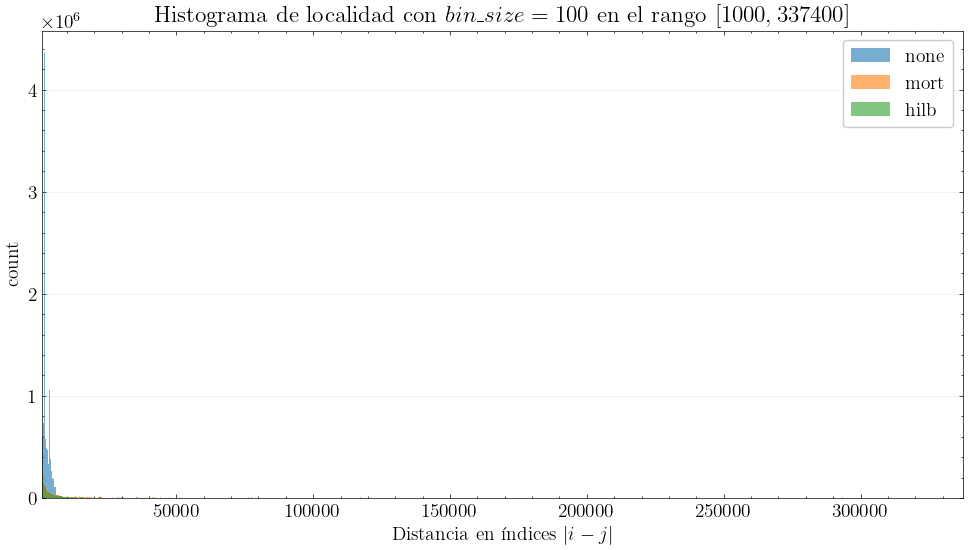

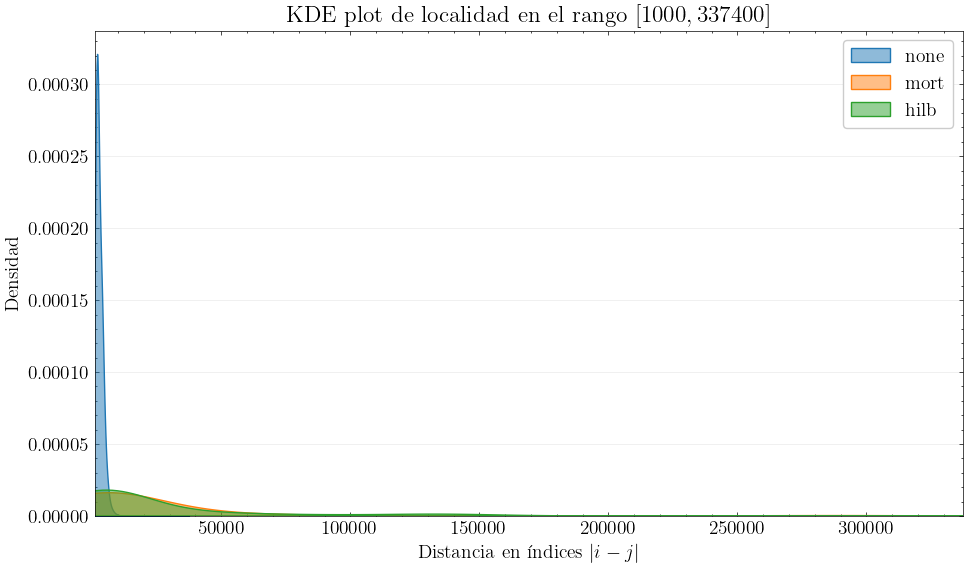

Encoder  Weighted Mean  Weighted Std Dev
   none    1853.552986       1596.435597
   mort    7254.988207      47962.606641
   hilb    4319.755291      32695.739693


In [122]:
show_visualizations("alcoy", 1000, 0.99, 100)

Loading latest file: locality_knn_50/Lille_0/Lille_0-none-locality.csv
Loading latest file: locality_knn_50/Lille_0/Lille_0-mort-locality.csv
Loading latest file: locality_knn_50/Lille_0/Lille_0-hilb-locality.csv
Distance limits for 99.0% of counts per dataset:
  none: 496900
  mort: 199500
  hilb: 201100
Using final plot limit = 496900


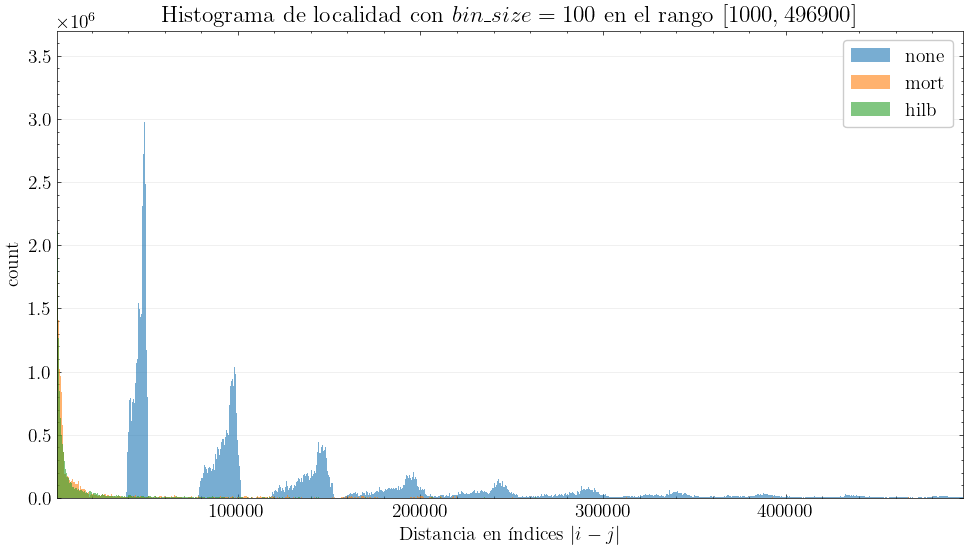

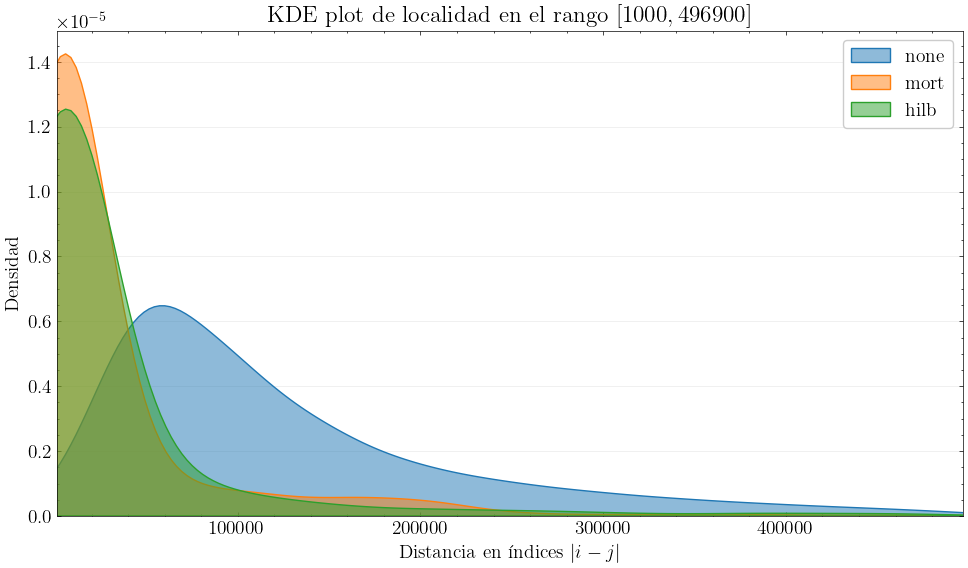

Encoder  Weighted Mean  Weighted Std Dev
   none  105221.769568     110477.727581
   mort   19354.499645     231864.932565
   hilb   15417.568178     200409.004055


In [123]:
show_visualizations("Lille_0", 1000, 0.99, 100)

Loading latest file: locality_knn_50/Paris_Luxembourg_6/Paris_Luxembourg_6-none-locality.csv
Loading latest file: locality_knn_50/Paris_Luxembourg_6/Paris_Luxembourg_6-mort-locality.csv
Loading latest file: locality_knn_50/Paris_Luxembourg_6/Paris_Luxembourg_6-hilb-locality.csv
Distance limits for 99.0% of counts per dataset:
  none: 1937600
  mort: 328500
  hilb: 200900
Using final plot limit = 1937600


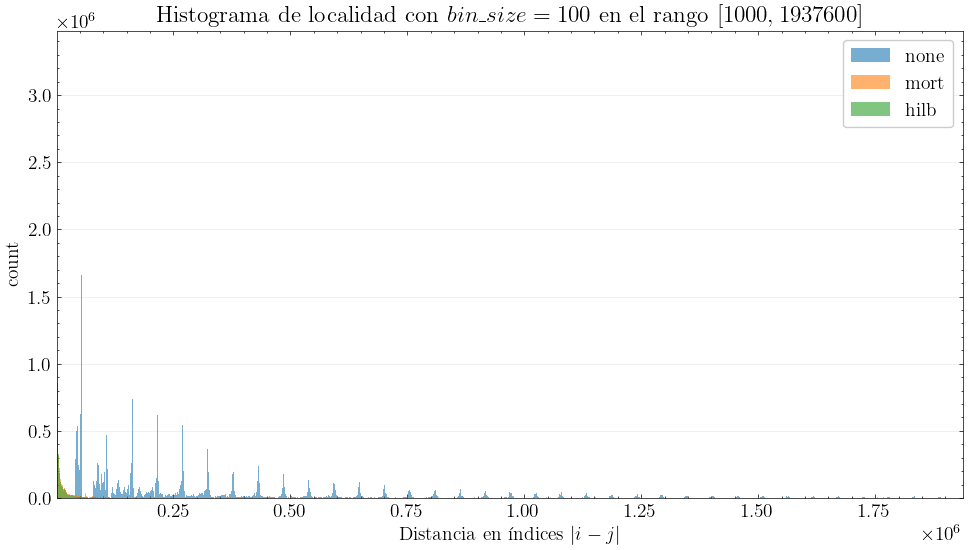

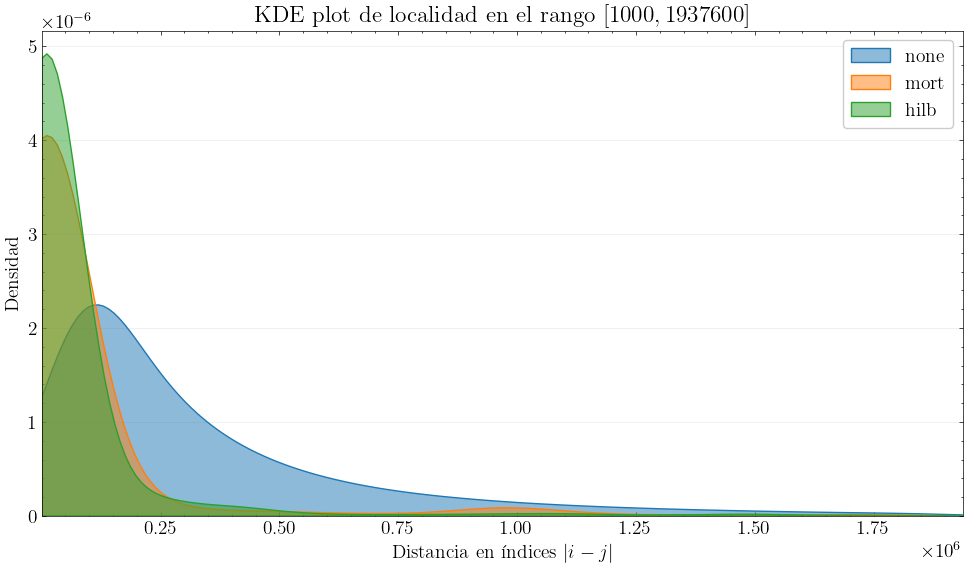

Encoder  Weighted Mean  Weighted Std Dev
   none  302254.992736     391701.401506
   mort   19272.843827     233655.455232
   hilb   15520.047509     210872.283738


In [124]:
show_visualizations("Paris_Luxembourg_6", 1000, 0.99, 100)

Loading latest file: locality_knn_50/5080_54400/5080_54400-none-locality.csv
Loading latest file: locality_knn_50/5080_54400/5080_54400-mort-locality.csv
Loading latest file: locality_knn_50/5080_54400/5080_54400-hilb-locality.csv
Distance limits for 99.0% of counts per dataset:
  none: 11028500
  mort: 601500
  hilb: 494500
Using final plot limit = 11028500


/tmp/ipykernel_47593/3282950773.py:23: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()
/home/pablo/pablo-diaz/.conda/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


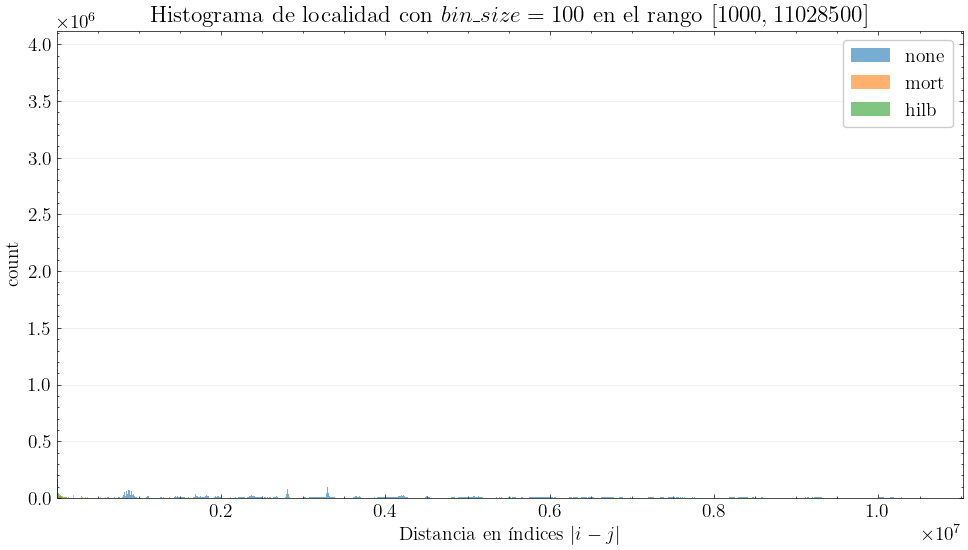

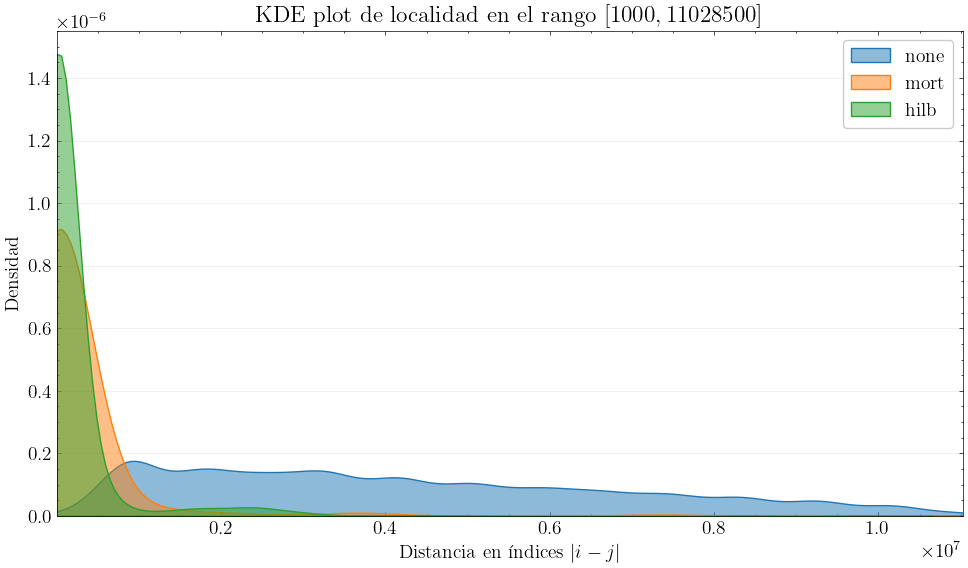

Encoder  Weighted Mean  Weighted Std Dev
   none   4.002768e+06      2.919510e+06
   mort   3.844322e+04      4.138449e+05
   hilb   2.346791e+04      2.398460e+05


In [125]:
show_visualizations("5080_54400", 1000, 0.99, 100)

## Escala logarítmica
También se puede plottear el histograma en escala logarítmica, en algunos casos hace que los picos sean más fáciles de distinguir y ayuda a quitar el efecto del límite inferior si no se ajusto bien $x_{min}$. 

Loading latest file: locality_knn_50/5080_54400/5080_54400-none-locality.csv
Loading latest file: locality_knn_50/5080_54400/5080_54400-mort-locality.csv
Loading latest file: locality_knn_50/5080_54400/5080_54400-hilb-locality.csv
Distance limits for 99.0% of counts per dataset:
  none: 11028500
  mort: 601500
  hilb: 494500
Using final plot limit = 11028500


/tmp/ipykernel_47593/3282950773.py:23: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()
/home/pablo/pablo-diaz/.conda/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


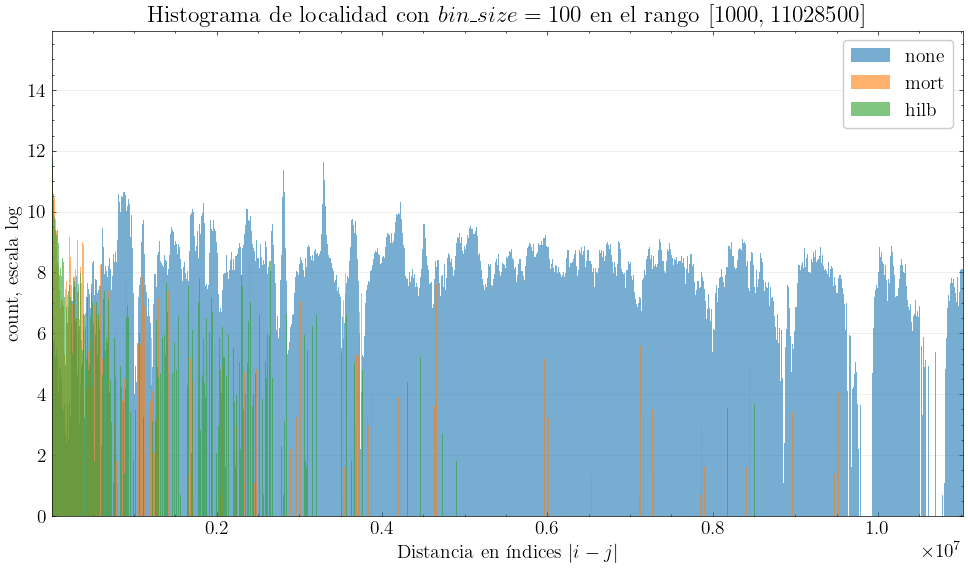

Encoder  Weighted Mean  Weighted Std Dev
   none   4.002768e+06      2.919510e+06
   mort   3.844322e+04      4.138449e+05
   hilb   2.346791e+04      2.398460e+05


In [126]:
show_visualizations("5080_54400", 1000, 0.99, 100, use_log=True, kde = False)